# code to recreate figure 2B, 2C, and 2D

In [5]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.patches as mpatches

client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    plt.close()
    
    return clustered_order

In [6]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list
FeCO_df= client.materialize.query_table('feco_axons_v0')
FeCO_df = FeCO_df[FeCO_df['classification_system'].str.contains('T1L')]
FeCO_df = FeCO_df.replace(to_replace='club_asc', value='club')

hook_ids = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['pt_root_id'].to_list()
hook_types = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['cell_type'].to_list()

claw_ids = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['pt_root_id'].to_list()
claw_types = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['cell_type'].to_list()

club_ids = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['pt_root_id'].to_list()
club_types = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['cell_type'].to_list()

allFeCO_ids = claw_ids+hook_ids+club_ids
allFeCO_types = claw_types+hook_types+club_types

C:\Users\swetarr\anaconda3\envs\connectomics\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [7]:
#find all the postsynaptic partners that receive more than 3 synapses from an FeCO neuron. This will give us a dataframe with a list of downstream neurons and how many synapses they receive from one of the 
# FeCO neurons. It is possible they receive more synapses total since we got rid of duplicate entries. We also don't 
# know who the upstream partner is, but the assumption is that we can deal with figuring that out when doing analysis.

syn_threshold = 3; 

outputs = client.materialize.synapse_query(pre_ids = allFeCO_ids)
syn_per_output = outputs.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_output = syn_per_output[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_output['number_of_synapses'] > syn_threshold]

inputs = client.materialize.synapse_query(post_ids = allFeCO_ids)
syn_per_input = inputs.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_input = syn_per_input[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_input['number_of_synapses'] >= syn_threshold]

out_partner_ids = syn_per_output.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()
in_partner_ids = syn_per_input.drop_duplicates(subset = "pre_pt_root_id")['pre_pt_root_id'].to_list()
all_partners = np.unique(out_partner_ids+in_partner_ids)

In [8]:
synapse_out_counts = client.materialize.query_view('synapse_out_counts', filter_in_dict={'root_id': all_partners})

lotsa_outputs_ids = synapse_out_counts.query('n_output>40')['root_id'].to_list()

notsmall_outputs = syn_per_output[syn_per_output['post_pt_root_id'].isin(lotsa_outputs_ids)]
notsmall_outputs_ids = np.unique(notsmall_outputs['post_pt_root_id'].to_list())

In [9]:
#compute similarity matrix of FeCO neurons based on their outputs, not small partners that receive 4+ synapses.
#separate similarity matrices for each FeCO subtype (club, claw, hook, maybeclub)

#hook
hookds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(hook_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(hook_ids):
        index1 += 1
        try:
            hookds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#claw
clawds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(claw_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(claw_ids):
        index1 += 1
        try:
            clawds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#club
clubds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(club_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(club_ids):
        index1 += 1
        try:
            clubds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#also the similarity matrix all of the FeCO neurons
allds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(allFeCO_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(allFeCO_ids):
        index1 += 1
        try:
            allds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
if index1-index2 == len(notsmall_outputs):
    print('huzzah!')

huzzah!


In [12]:
# compute similarity, perform clustering on each subtype matrix. We'll use the ordering of the rows to reorder the all FeCO matrix

#hook
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
hookds_similarity_matrix = cosine_similarity(hookds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(hookds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
h_order_rows = plot_dendrogram(model, truncate_mode="level", p=hookds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
h_order_rows = np.array(h_order_rows).astype(int) # Convert strings to integers
hookds_connectivity_matrix_clustered_rows = hookds_connectivity_matrix[h_order_rows, :]
hook_dsids_clustered = np.array(notsmall_outputs_ids)[h_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
hookds_similarity_matrix = cosine_similarity(np.transpose(hookds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(hookds_similarity_matrix)
h_order_cols = plot_dendrogram(model, truncate_mode="level", p=hookds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
h_order_cols = np.array(h_order_cols).astype(int)
hookds_connectivity_matrix_clustered_rows_cols = hookds_connectivity_matrix_clustered_rows[:, h_order_cols]
hookids_clustered = np.array(hook_ids)[h_order_cols].tolist()
hooktypes_clustered = np.array(hook_types)[h_order_cols].tolist()

hookds_similarity_matrix = hookds_similarity_matrix[h_order_cols, :]
hookds_similarity_matrix = hookds_similarity_matrix[:, h_order_cols]


#claw
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
clawds_similarity_matrix = cosine_similarity(clawds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clawds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
cw_order_rows = plot_dendrogram(model, truncate_mode="level", p=clawds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
cw_order_rows = np.array(cw_order_rows).astype(int) # Convert strings to integers
clawds_connectivity_matrix_clustered_rows = clawds_connectivity_matrix[cw_order_rows, :]
claw_dsids_clustered = np.array(notsmall_outputs_ids)[cw_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
clawds_similarity_matrix = cosine_similarity(np.transpose(clawds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clawds_similarity_matrix)
cw_order_cols = plot_dendrogram(model, truncate_mode="level", p=clawds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
cw_order_cols = np.array(cw_order_cols).astype(int)
clawds_connectivity_matrix_clustered_rows_cols = clawds_connectivity_matrix_clustered_rows[:, cw_order_cols]
clawids_clustered = np.array(claw_ids)[cw_order_cols].tolist()
clawtypes_clustered = np.array(claw_types)[cw_order_cols].tolist()

clawds_similarity_matrix = clawds_similarity_matrix[cw_order_cols, :]
clawds_similarity_matrix = clawds_similarity_matrix[:, cw_order_cols]

#club
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
clubds_similarity_matrix = cosine_similarity(clubds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clubds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
cb_order_rows = plot_dendrogram(model, truncate_mode="level", p=clubds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
cb_order_rows = np.array(cb_order_rows).astype(int) # Convert strings to integers
clubds_connectivity_matrix_clustered_rows = clubds_connectivity_matrix[cb_order_rows, :]
club_dsids_clustered = np.array(notsmall_outputs_ids)[cb_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
clubds_similarity_matrix = cosine_similarity(np.transpose(clubds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clubds_similarity_matrix)
cb_order_cols = plot_dendrogram(model, truncate_mode="level", p=clubds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
cb_order_cols = np.array(cb_order_cols).astype(int)
clubds_connectivity_matrix_clustered_rows_cols = clubds_connectivity_matrix_clustered_rows[:, cb_order_cols]
clubids_clustered = np.array(club_ids)[cb_order_cols].tolist()
clubtypes_clustered = np.array(club_types)[cb_order_cols].tolist()

clubds_similarity_matrix = clubds_similarity_matrix[cb_order_cols, :]
clubds_similarity_matrix = clubds_similarity_matrix[:, cb_order_cols]


all_order_cols = np.concatenate([cw_order_cols, h_order_cols+len(claw_ids), cb_order_cols+len(hook_ids)+len(claw_ids)]) 

rearranged_clusteredFeCOids = np.array(allFeCO_ids)[all_order_cols].tolist()
rearranged_clusteredFeCOtypes = np.array(allFeCO_types)[all_order_cols].tolist()

In [13]:
#change HL or cell type designations to NT designations:
Ach_HL = ['1A', '3A', '4B', '7B', '8B', '10B', '11A', '12A', '17A', '18B', '19B', 
          '20A', '22A', '23B', 'MN', 'sensory', 'hook', 'hair_plate', 'claw', 'club']

Glu_HL = ['2A', '8A', '9B', '14A', '15B', '16B', '21A', '24B']

GABA_HL = ['0A/0B', '1B', '3B', '5B', '6A', '9A','12B', '6B', '11B', '13A', 
           '13B', '19A']

U_HL = ['10B-like', '16A']
frag = ['fragment']

In [14]:
#Load in the classification data for the partners of FeCO neurons!

downstream_AT= client.materialize.query_table('downstream_feco_axons_v1')

pd.set_option('display.max_rows', 600)
# downstream_AT

# add in NT values for motor and sensory neurons, which are not in either table yet
def fill_NT(row):
    if row['cell_type'] in Glu_HL:
        return 'Glu'
    elif row['cell_type'] in Ach_HL:
        return 'Ach'
    elif row['cell_type'] in GABA_HL:
        return 'GABA'
    elif row['cell_type'] in U_HL:
        return 'unknown'
    elif row['cell_type'] == 'fragment':
        return 'fragment'
    else:
        return 'unknown'
    
    
downstream_AT['Neurotransmitter'] = downstream_AT.apply(lambda row : fill_NT(row), axis=1) 

In [16]:
NT_categories = ['Ach', 'GABA', 'Glu', 'unknown', 'fragment']

classification_categories = ['ascending', 'intersegmental', 'decending', 'local', 'MN', 'sensory', 'unknown', 'fragment']

In [17]:
#loop through each sensory neuron (in order suggested by cosine similarity) and consolidate information into a few different lists:
#includes both numbers of neurons (counts) and numbers of synapses (syns)

outputinfo = pd.DataFrame()

#find all post_pt_root_id downstream of that sensory neuron from syn_per_output, plus number of synapses

FeCOids = []
FeCOtypes = []
all_output_ids = []
all_output_HLcounts = []
all_output_NTcounts = []
all_output_classcounts = []
all_output_HLsyns = []
all_output_NTsyns = []
all_output_classsyns = []

for i, segid in enumerate(rearranged_clusteredFeCOids):
    FeCOids.append(segid)
    FeCOtypes.append(rearranged_clusteredFeCOtypes[i])
    
    ############## working on outputs first ##################
    #find segids of output partners
    output_ids = syn_per_output.loc[syn_per_output['pre_pt_root_id']==segid].post_pt_root_id.tolist()
    syn_per_partner = syn_per_output.loc[syn_per_output['pre_pt_root_id']==segid].number_of_synapses.tolist()
    
    syn_per_partner = dict(zip(output_ids, syn_per_partner)) #create dictionary with the output id and the number of synapses
    all_output_ids.append(syn_per_partner)    
    
    #classify information about those partners, and also count how many we don't know anything about
    types = (downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]['classification_system'].tolist())
    HLs = (downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]['cell_type'].tolist())
#     print(HLs)
    NTs = (downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]['Neurotransmitter'].tolist())
    this_subset = downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]
    
    #number of partner ids that are not in the detailed table:
    n_unproofread = (len(list(set(output_ids)-set(downstream_AT.pt_root_id))))
    unproofed_syn = sum(syn_per_partner[item] for item in list(set(output_ids)-set(downstream_AT.pt_root_id)))
    
    #number of neurons and number of synapses in each HL
    HL_counts = [0] *(len(HL_categories)+1)
    HL_counts_syn = [0] *(len(HL_categories)+1)
    
    for j, hl in enumerate(HL_categories):
        HL_counts[j] = HLs.count(hl)
        HL_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['cell_type'].isin([hl])]['pt_root_id'].tolist())
        
    HL_counts[-1] = n_unproofread
    HL_counts_syn[-1] = unproofed_syn
    
    #number of neurons and number of synapses with each NT
    NT_counts = [0] *(len(NT_categories)+1)
    NT_counts_syn = [0] *(len(NT_categories)+1) 
        
    for j, nt in enumerate(NT_categories):
        NT_counts[j] = NTs.count(nt)
        NT_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['Neurotransmitter'].isin([nt])]['pt_root_id'].tolist())

    NT_counts[-1] = n_unproofread
    NT_counts_syn[-1] = unproofed_syn
    
    #number of neurons and number of synapses in each class
    class_counts = [0] *(len(classification_categories)+1)
    class_counts_syn = [0] *(len(classification_categories)+1)
    
    for j, ct in enumerate(classification_categories):
        class_counts[j] = ' '.join(types).count(ct)
        class_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['classification_system'].str.contains(ct)]['pt_root_id'].tolist())
                                  
#     class_counts[-2] = sum(pd.isna(x) for x in types) #count number that we can't classify
#     class_counts_syn[-2] = sum(syn_per_partner[item] for item in this_subset[pd.isna(this_subset['classification_system'])]['pt_root_id'].tolist())
    
    class_counts[-1] = n_unproofread
    class_counts_syn[-1] = unproofed_syn
    
    all_output_HLcounts.append(HL_counts)
    all_output_NTcounts.append(NT_counts)
    all_output_classcounts.append(class_counts)
    
    all_output_HLsyns.append(HL_counts_syn)
    all_output_NTsyns.append(NT_counts_syn)
    all_output_classsyns.append(class_counts_syn)
    
    
outputinfo['FeCO_id'] = FeCOids
outputinfo['FeCO_type'] = FeCOtypes
outputinfo['partner_ids'] = all_output_ids
outputinfo['HL_counts'] = all_output_HLcounts
outputinfo['NT_counts'] = all_output_NTcounts
outputinfo['class_counts'] = all_output_classcounts
outputinfo['HL_syns'] = all_output_HLsyns
outputinfo['NT_syns'] = all_output_NTsyns
outputinfo['class_syns'] = all_output_classsyns

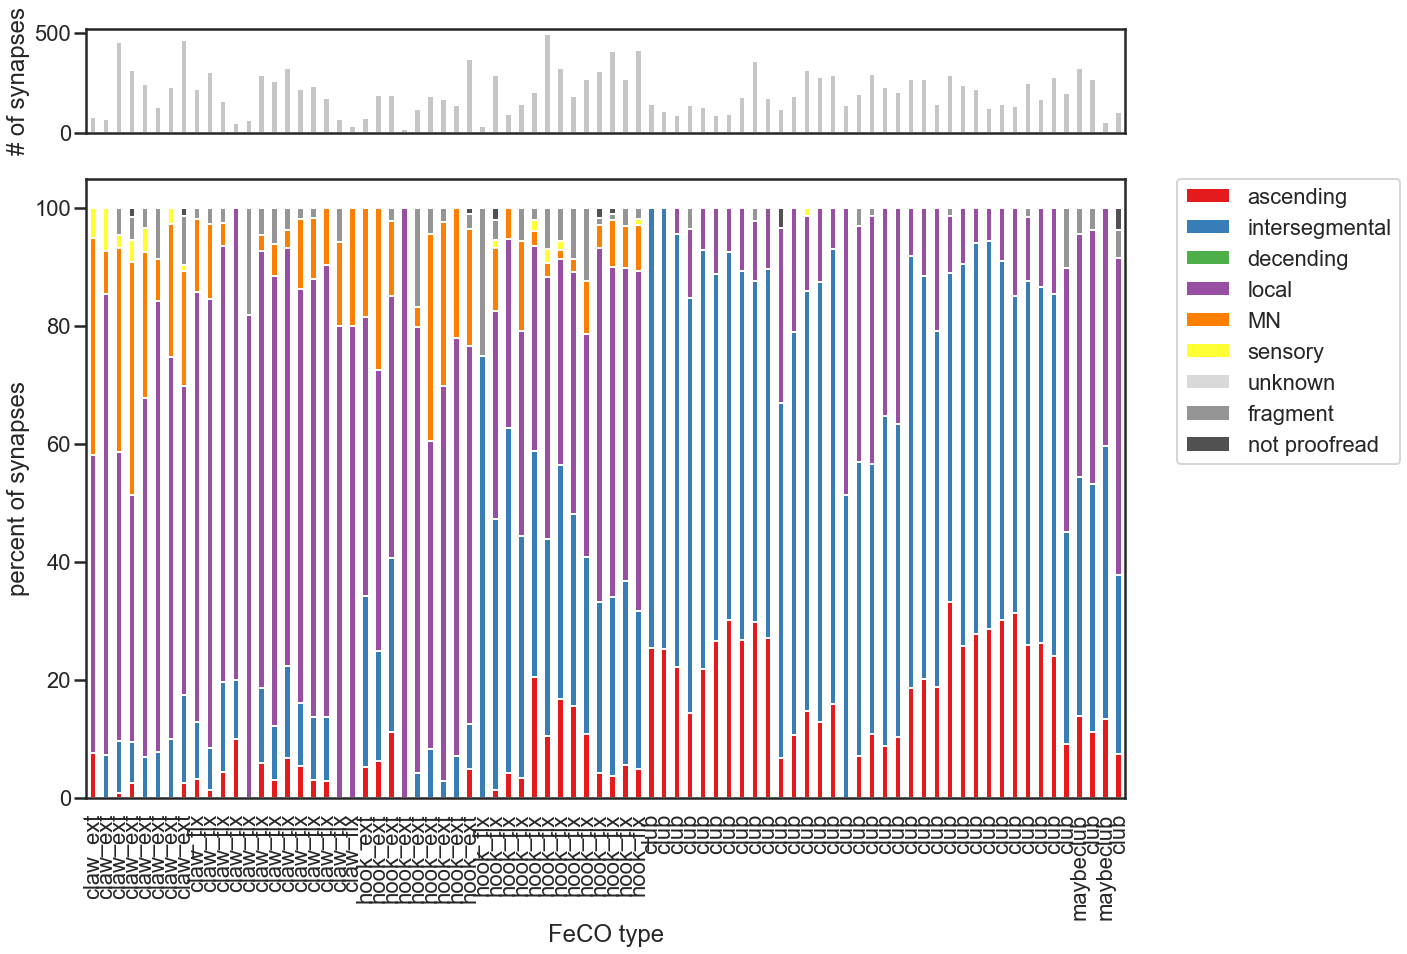

In [18]:

#initialize some figure stuff
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("poster")

#number of synapses
classification_categories = ['ascending', 'intersegmental', 'decending', 'local', 'MN', 'sensory', 'unknown', 'fragment', 'not proofread']
n_syns = pd.DataFrame(outputinfo['class_syns'].tolist(), index=outputinfo['FeCO_type'], columns=classification_categories)
normalized_n_syns = n_syns.divide(n_syns.sum(axis=1, numeric_only=True), axis=0)*100
summedsyns = n_syns.sum(axis=1, numeric_only=True)


f ,axs =plt.subplots(2,1,figsize=(16,12), sharey=False, sharex=True, gridspec_kw={'height_ratios': [0.5, 3]})
f.tight_layout()

sns.set_palette(sns.color_palette("Greys", 2))
summedsyns.plot(kind='bar', stacked=True, ax=axs[0])

sns.set_palette(sns.color_palette("Set1", len(classification_categories)-3) + sns.color_palette("Greys", 3))
normalized_n_syns.plot(kind='bar', stacked=True, ax=axs[1])

#set some more figure stuff
axs[0].set(ylabel='# of synapses')
axs[0].tick_params(bottom=False)
axs[1].set(xlabel='FeCO type')
axs[1].set(ylabel='percent of synapses')
axs[1].tick_params(bottom=False)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()



In [20]:
grouped_nsyns = n_syns.groupby(level=0).sum()
grouped_nsyns = grouped_nsyns.drop(columns=['decending', 'unknown'])

normalized_grouped_nsyns = grouped_nsyns.divide(grouped_nsyns.sum(axis=1, numeric_only=True), axis=0)*100

,ascending,intersegmental,local,MN,sensory,fragment,not proofread
FeCO_type,,,,,,,
claw_ext,1.512859,9.379728,54.765507,26.575895,2.622289,4.589007,0.554715
claw_flx,3.915035,10.453978,74.427322,7.830071,0.000000,3.373594,0.000000
club,19.486955,61.157266,18.218919,0.000000,0.058301,0.961959,0.116601
hook_ext,3.800968,12.093988,59.364202,21.354527,0.000000,3.109883,0.276434
hook_flx,8.236321,34.691502,45.343423,5.937136,0.844005,4.511059,0.436554
maybeclub,13.866667,41.333333,41.066667,0.000000,0.000000,3.733333,0.000000


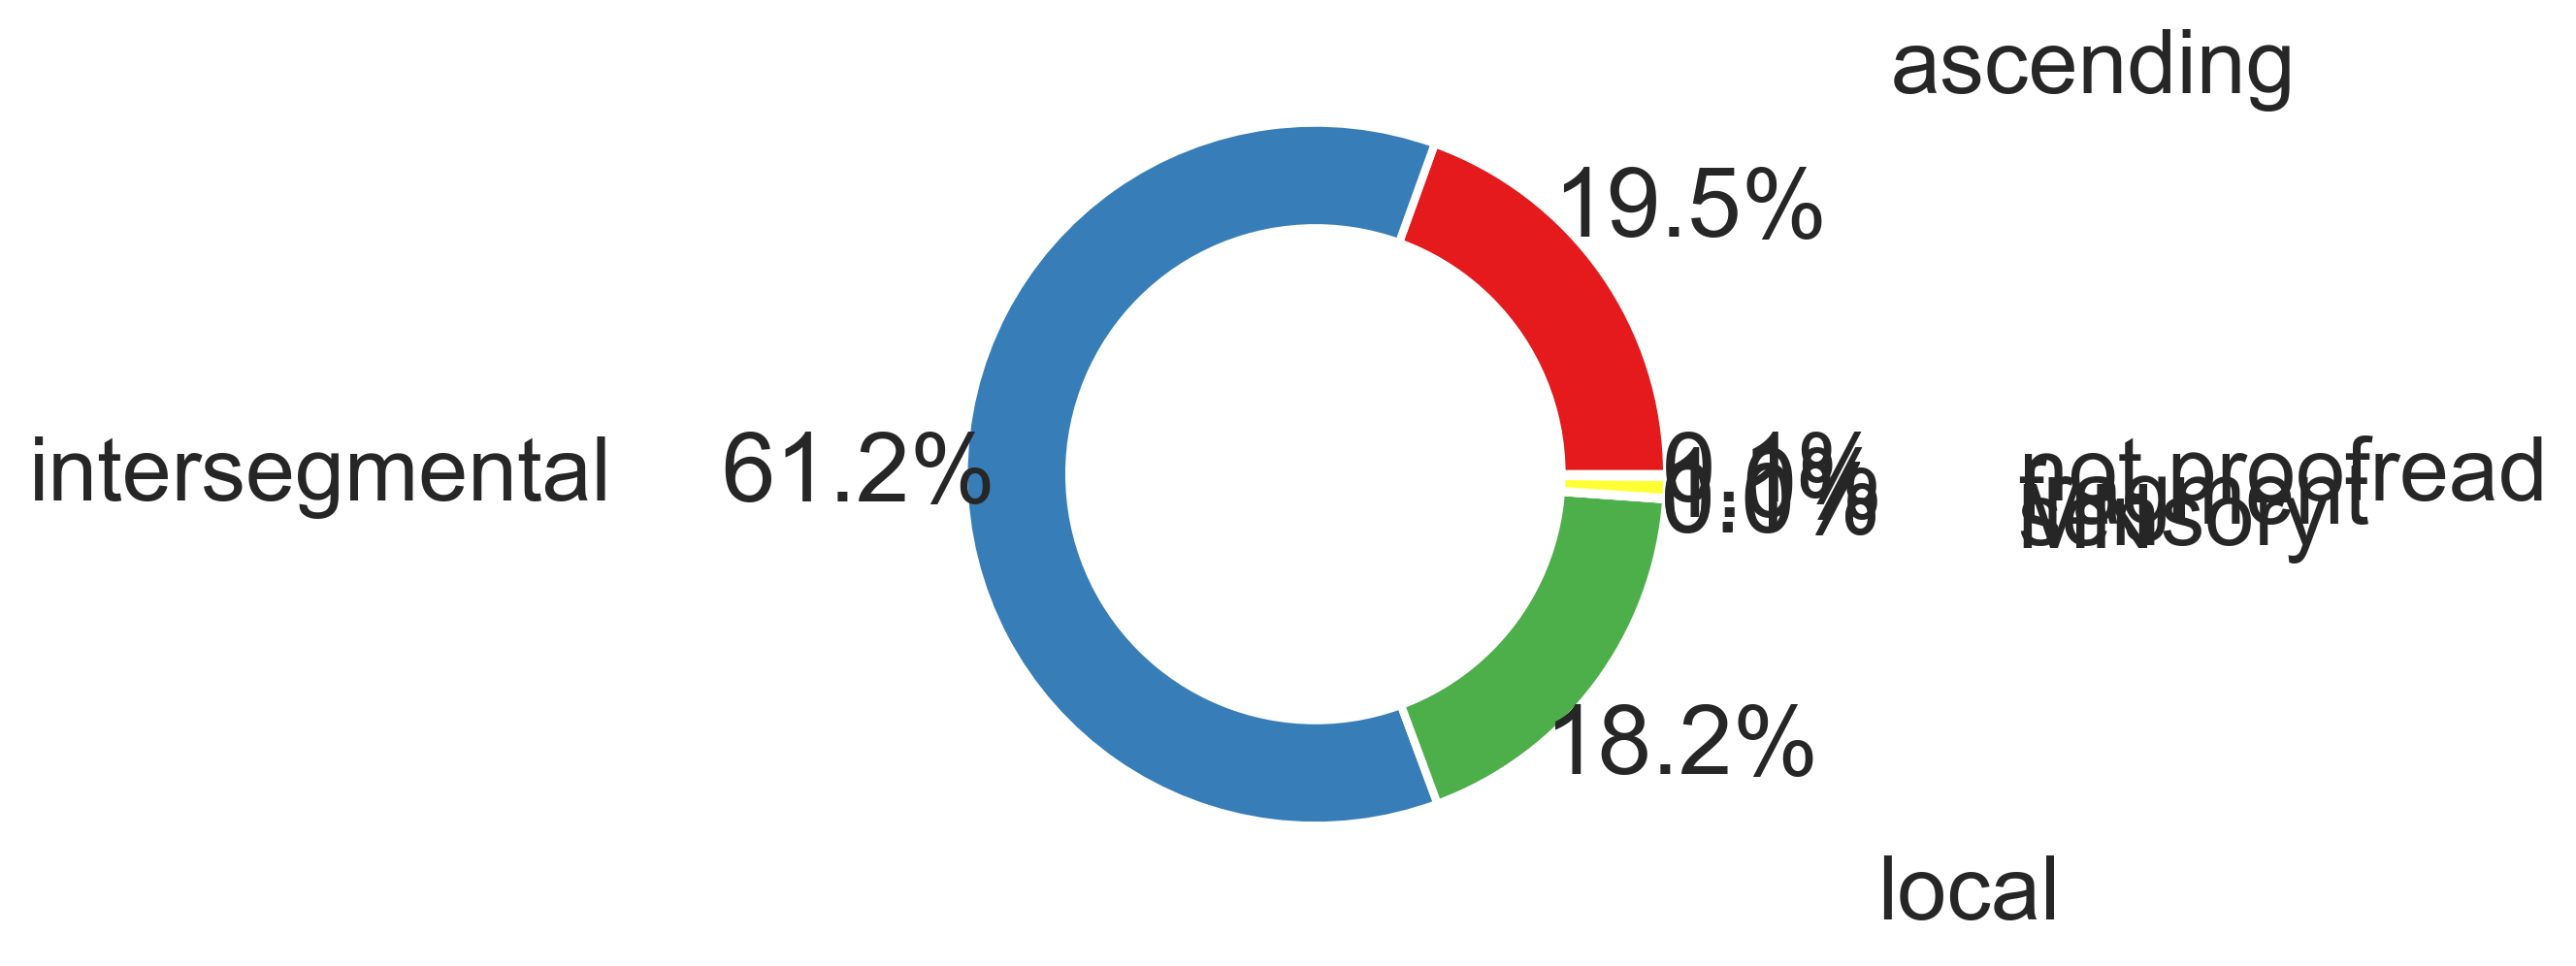

In [21]:
plt.rcParams['figure.dpi'] = 300

# data = [avlp_sum, sad_sum, wed_sum, gng_sum]
keys = ['ascending', 'intersegmental', 'local', 'MN', 'sensory', 'fragment', 'not proofread']
# palette_color = sns.color_palette('BuPu')

plt.pie(grouped_nsyns.loc['club'].values, labels = keys, autopct='%.1f%%', labeldistance = 2, pctdistance = 1.3)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

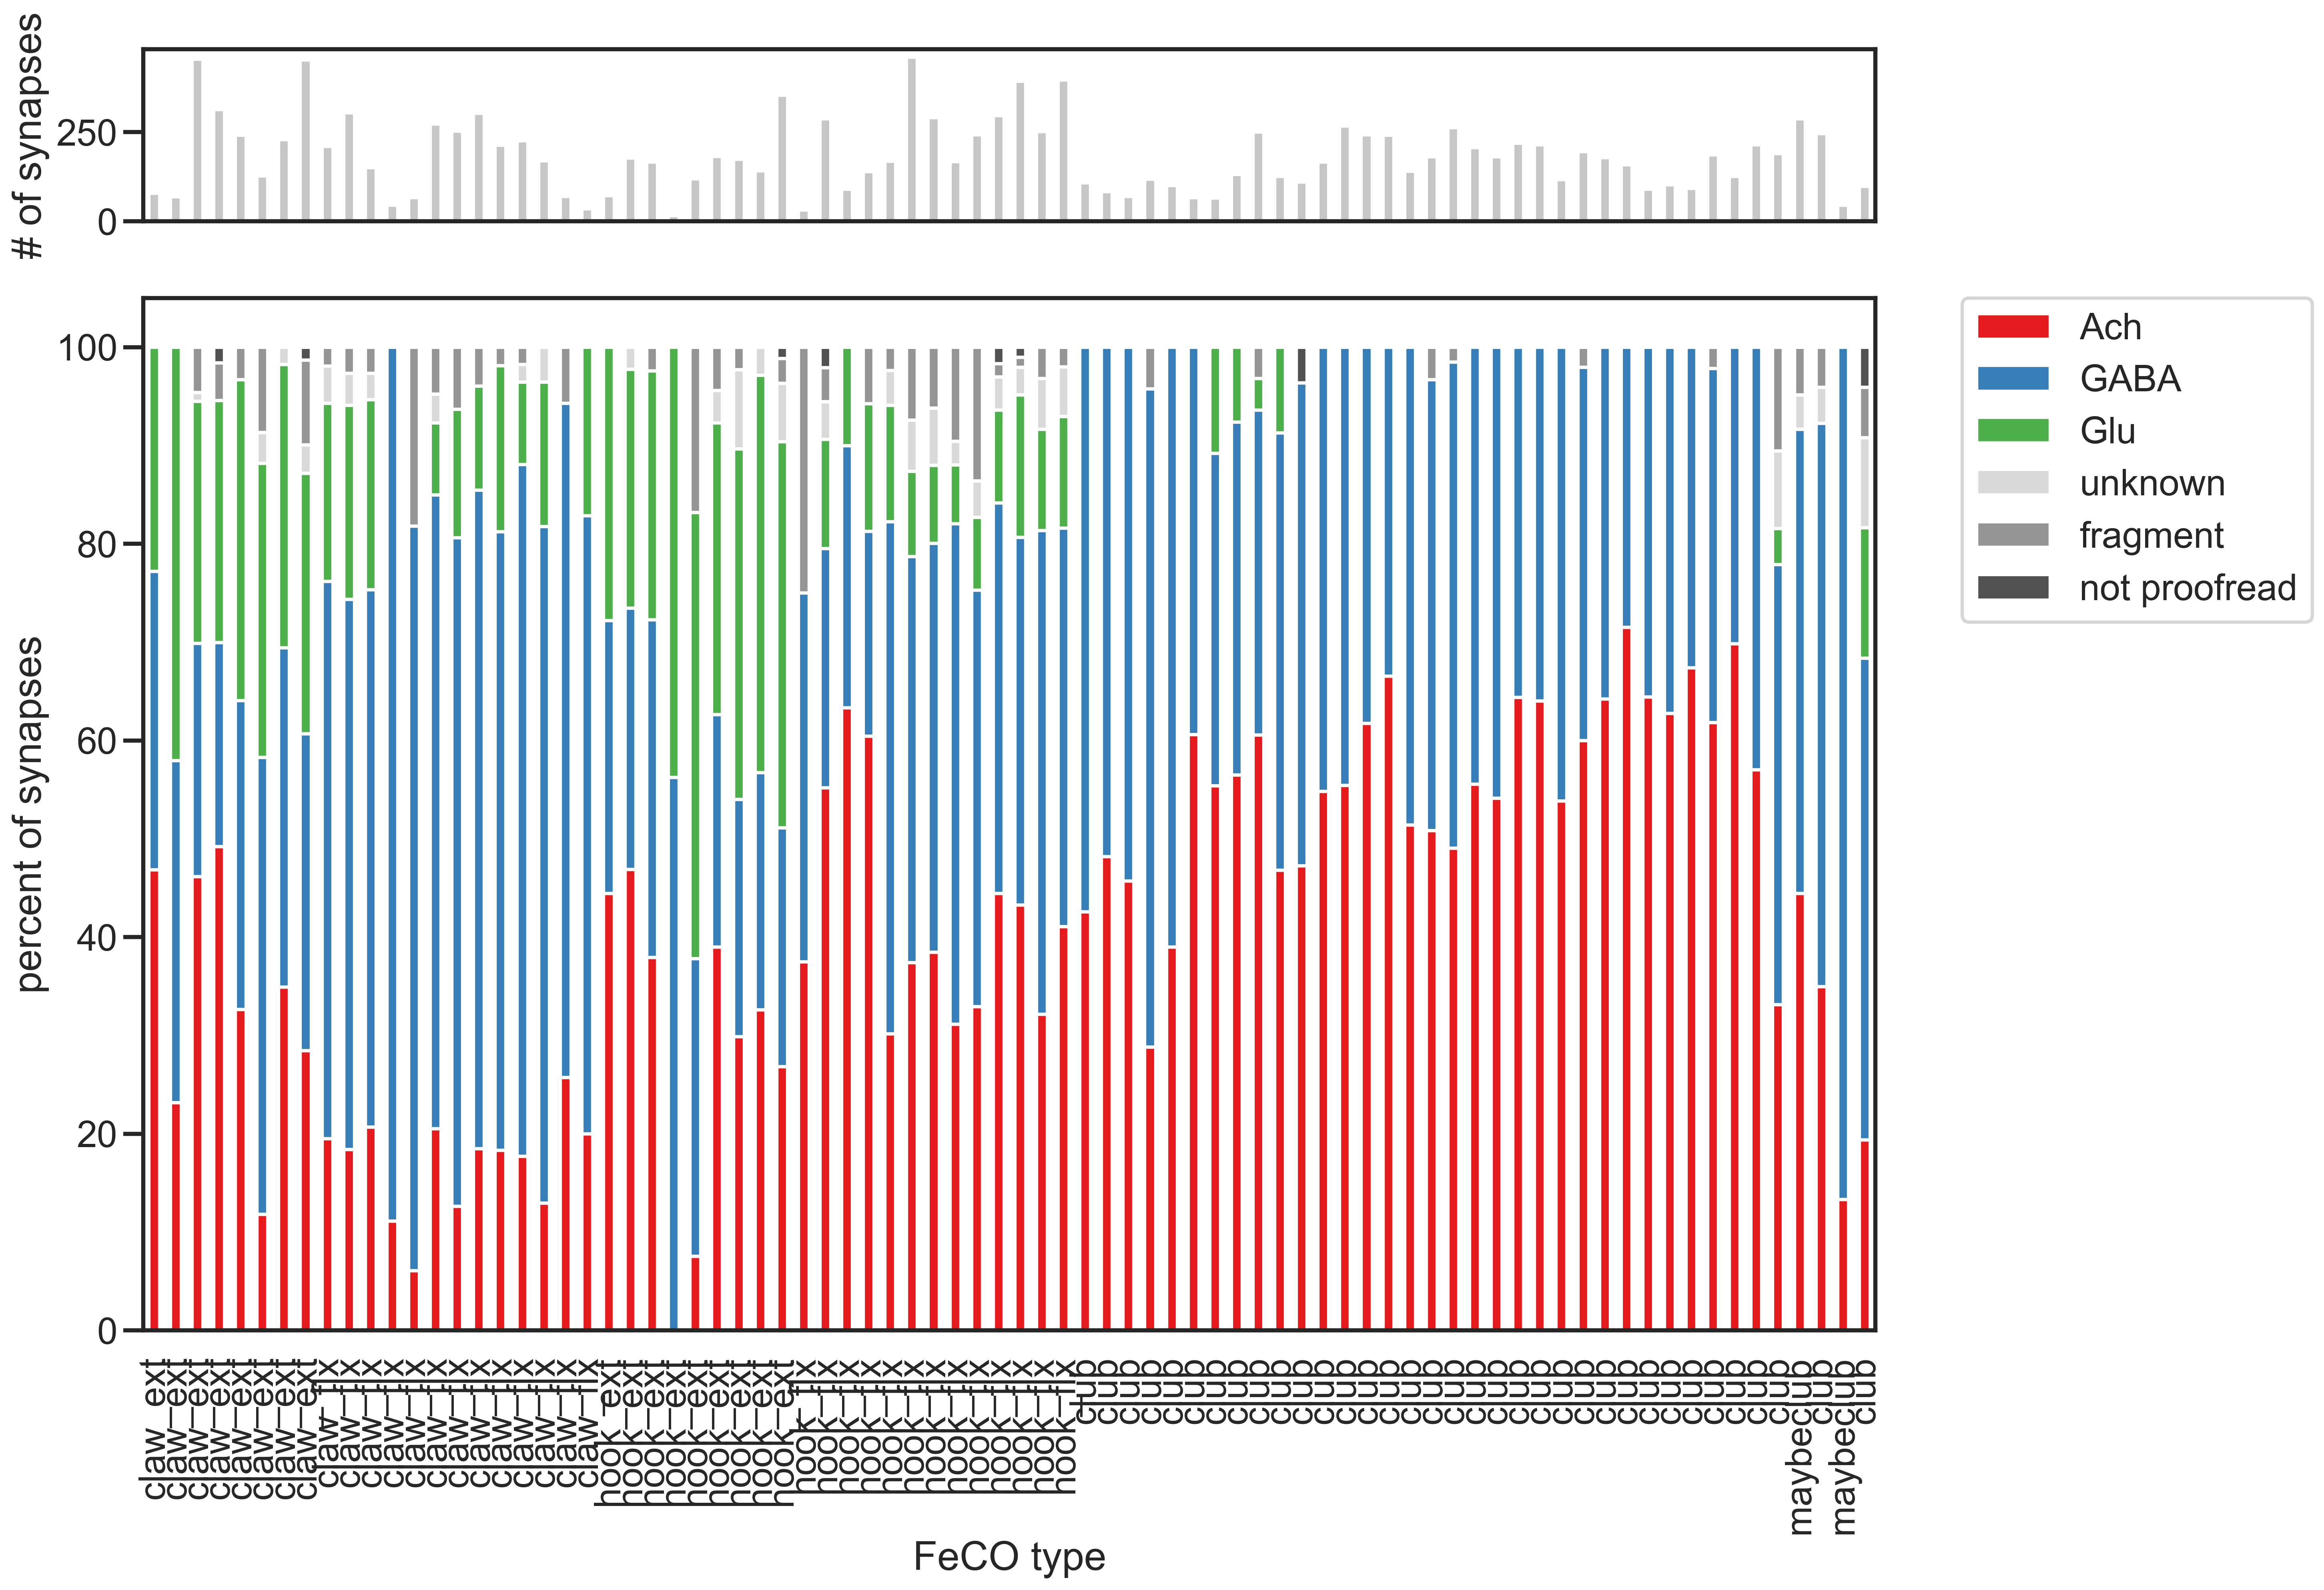

In [23]:
###### distribution of neurotransmitter expression ######
classification_categories = ['Ach', 'GABA', 'Glu', 'unknown', 'fragment', 'not proofread']

#number of synapses
n_syns = pd.DataFrame(outputinfo['NT_syns'].tolist(), index=outputinfo['FeCO_type'], columns=classification_categories)
normalized_n_syns = n_syns.divide(n_syns.sum(axis=1, numeric_only=True), axis=0)*100
summedsyns = n_syns.sum(axis=1, numeric_only=True)

f ,axs =plt.subplots(2,1,figsize=(16,12), sharey=False, sharex=True, gridspec_kw={'height_ratios': [0.5, 3]})
f.tight_layout()

sns.set_palette(sns.color_palette("Greys", 2))
summedsyns.plot(kind='bar', stacked=True, ax=axs[0])

sns.set_palette(sns.color_palette("Set1", len(classification_categories)-3) + sns.color_palette("Greys", 3))
normalized_n_syns.plot(kind='bar', stacked=True, ax=axs[1])

#set some more figure stuff

axs[0].set(ylabel='# of synapses')
axs[0].tick_params(bottom=False)


axs[1].set(xlabel='FeCO type')
axs[1].set(ylabel='percent of synapses')
axs[1].tick_params(bottom=False)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()